In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Extract Start and Peak Dates for Each Stock

In [ ]:
import pandas as pd


def process_stock_file(file_path, stock_name):

    stock_data = pd.read_excel(file_path)

    # Convert Date column to datetime
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])


    stock_data = stock_data.sort_values('Date').reset_index(drop=True)


    stock_data = stock_data.set_index('Date').asfreq('D', method='ffill').reset_index()


    def find_pump_and_dump_period(data):
        # Identify the start date (earliest date)
        start_date = data['Date'].iloc[0]
        start_price = data['Last Price'].iloc[0]

        # Identify the peak date (date with the highest price)
        peak_date = data['Date'][data['Last Price'].idxmax()]
        peak_price = data['Last Price'].max()

        return start_date, peak_date, start_price, peak_price


    start_date, peak_date, start_price, peak_price = find_pump_and_dump_period(stock_data)


    return pd.DataFrame({
        'Stock': [stock_name],
        'Start Date': [start_date],
        'Start Price': [start_price],
        'Peak Date': [peak_date],
        'Peak Price': [peak_price]
    })


base_path = '/content/drive/MyDrive/wallstreet_data/BB/'


files_and_stocks = [
    ('Bloomberg_AMC_cleaned_flagged.xlsx', 'AMC'),
    ('Bloomberg_GameStop_cleaned_flagged.xlsx', 'GME'),
    ('Bloomberg_BB_cleaned_flagged.xlsx', 'BB'),
    ('Bloomberg_KOSS_cleaned_flagged.xlsx', 'KOSS')
]


result_dfs = [process_stock_file(base_path + file_name, stock_name) for file_name, stock_name in files_and_stocks]


final_result_df = pd.concat(result_dfs, ignore_index=True)


print(final_result_df)


final_result_path = base_path + 'pump_and_dump_summary.xlsx'
final_result_df.to_excel(final_result_path, index=False)

print(f"Summary of pump and dump periods saved to {final_result_path}")


stock_dates = {row['Stock']: (row['Start Date'], row['Peak Date']) for _, row in final_result_df.iterrows()}


stock_dates_df = pd.DataFrame(stock_dates).T.reset_index()
stock_dates_df.columns = ['Stock', 'Start Date', 'Peak Date']
stock_dates_df.to_csv('/content/drive/MyDrive/wallstreet_data/stock_dates.csv', index=False)


  Stock          Start Date  Start Price           Peak Date  Peak Price
0   AMC 2021-05-03 14:29:00        10.08 2021-06-18 14:29:00      61.675
1   GME 2020-12-31 01:03:00        19.26 2021-01-28 01:03:00     347.510
2    BB 2020-11-02 14:29:00         4.53 2021-01-27 14:29:00      20.320
3  KOSS 2020-12-01 00:59:00         2.16 2021-01-30 00:59:00      64.000
Summary of pump and dump periods saved to /content/drive/MyDrive/wallstreet_data/BB/pump_and_dump_summary.xlsx


# Social media Data Cleaning

In [ ]:
import pandas as pd
from textblob import TextBlob
import os


stock_dates = pd.read_csv('/content/drive/MyDrive/wallstreet_data/stock_dates.csv')
stock_dates_dict = {row['Stock']: (row['Start Date'], row['Peak Date']) for _, row in stock_dates.iterrows()}

print("Loaded stock dates.")
print(stock_dates_dict)


def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(text).sentiment.polarity


directory_path = '/content/drive/MyDrive/wallstreet_data/main/Original'


for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):

        stock_name = filename.split('_')[1].split('.')[0]  # Extract the stock name

        if stock_name in stock_dates_dict:
            start_date, peak_date = stock_dates_dict[stock_name]
            csv_path = os.path.join(directory_path, filename)

            print(f"Processing file: {csv_path} with start_date: {start_date} and peak_date: {peak_date}")


            df = pd.read_csv(csv_path)
            print(f"Loaded data from {csv_path}")


            df['post_created'] = pd.to_datetime(df['post_created'], errors='coerce')
            start_date = pd.to_datetime(start_date)
            peak_date = pd.to_datetime(peak_date)


            df = df[(df['post_created'] >= start_date) & (df['post_created'] <= peak_date)]
            print(f"Data after date filtering: {len(df)} records found.")


            df = df[~df['replier_name'].isin(["", "Deleted", "deleted"])]
            df = df[~df['commenter_name'].isin(["", "Deleted", "deleted"])]


            df['post_sentiment'] = df['post_body'].apply(get_sentiment)
            df['comment_sentiment'] = df['comment_body'].apply(get_sentiment)
            df['reply_sentiment'] = df['reply_body'].apply(get_sentiment)


            filtered_csv_path = os.path.join(directory_path, f"filtered_{filename}")
            df.to_csv(filtered_csv_path, index=False)
            print(f"Filtered data saved to {filtered_csv_path}")
        else:
            print(f"Stock name {stock_name} not in stock_dates_dict")


Step 1: Loading stock dates...
Loaded stock dates.
{'AMC': ('2021-05-03 14:29:00', '2021-06-18 14:29:00'), 'GME': ('2020-12-31 01:03:00', '2021-01-28 01:03:00'), 'BB': ('2020-11-02 14:29:00', '2021-01-27 14:29:00'), 'KOSS': ('2020-12-01 00:59:00', '2021-01-30 00:59:00')}
Processing file: /content/drive/MyDrive/wallstreet_data/main/Original/wallstreetbets_AMC.csv with start_date: 2021-05-03 14:29:00 and peak_date: 2021-06-18 14:29:00
Loaded data from /content/drive/MyDrive/wallstreet_data/main/Original/wallstreetbets_AMC.csv
Data after date filtering: 52745 records found.
Filtered data saved to /content/drive/MyDrive/wallstreet_data/main/Original/filtered_wallstreetbets_AMC.csv
Processing file: /content/drive/MyDrive/wallstreet_data/main/Original/wallstreetbets_BB.csv with start_date: 2020-11-02 14:29:00 and peak_date: 2021-01-27 14:29:00
Loaded data from /content/drive/MyDrive/wallstreet_data/main/Original/wallstreetbets_BB.csv
Data after date filtering: 10088 records found.
Filtered d

# Community Detection and Best Influencer

Loaded data from /content/drive/MyDrive/wallstreet_data/main/Original/filtered_wallstreetbets_AMC.csv
Graph created with 11463 nodes and 27021 edges
Found 34 communities
Best community based on modularity score: ['--Blightsaber--', '--X0X0--', '-Belzbel-', '100catactivs', '141_1337', '21archman21', 'Accomplished_Day6078', 'AdNo7052', 'AdamOolong', 'Aderhold22', 'Aggressivecleaning', 'American--American', 'Andy-Traveller', 'AntiCircleCopulation', 'Aoiboshi', 'Apptubrutae', 'Artcat81', 'Atomaardappel', 'Atrocious_1', 'Awkward-Painter-2024', 'Azeron955', 'Bad_Rowboat91', 'BassGaming', 'BennosukeMusashi', 'BestUdyrBR', 'Biocube16', 'BitcoinSaveMe', 'Blibbernut', 'Bob_Cockwrangler', 'Bobloblawblablabla', 'Bottleofbombay', 'BottomFeader', 'BoxoMorons', 'BrkTrdr', 'Broder45', 'Brofey', 'Bruh_lmaooooo', 'Bweeze086', 'CFogan', 'Caleb_Krawdad', 'Capital_List_1210', 'CatBreathWhiskers', 'Cat_From_Jupiter', 'Chickenmcnugs34', 'Chipsandadrink666', 'ChonkStonkz', 'Chrisophogus', 'ClifftheTinner', 'C

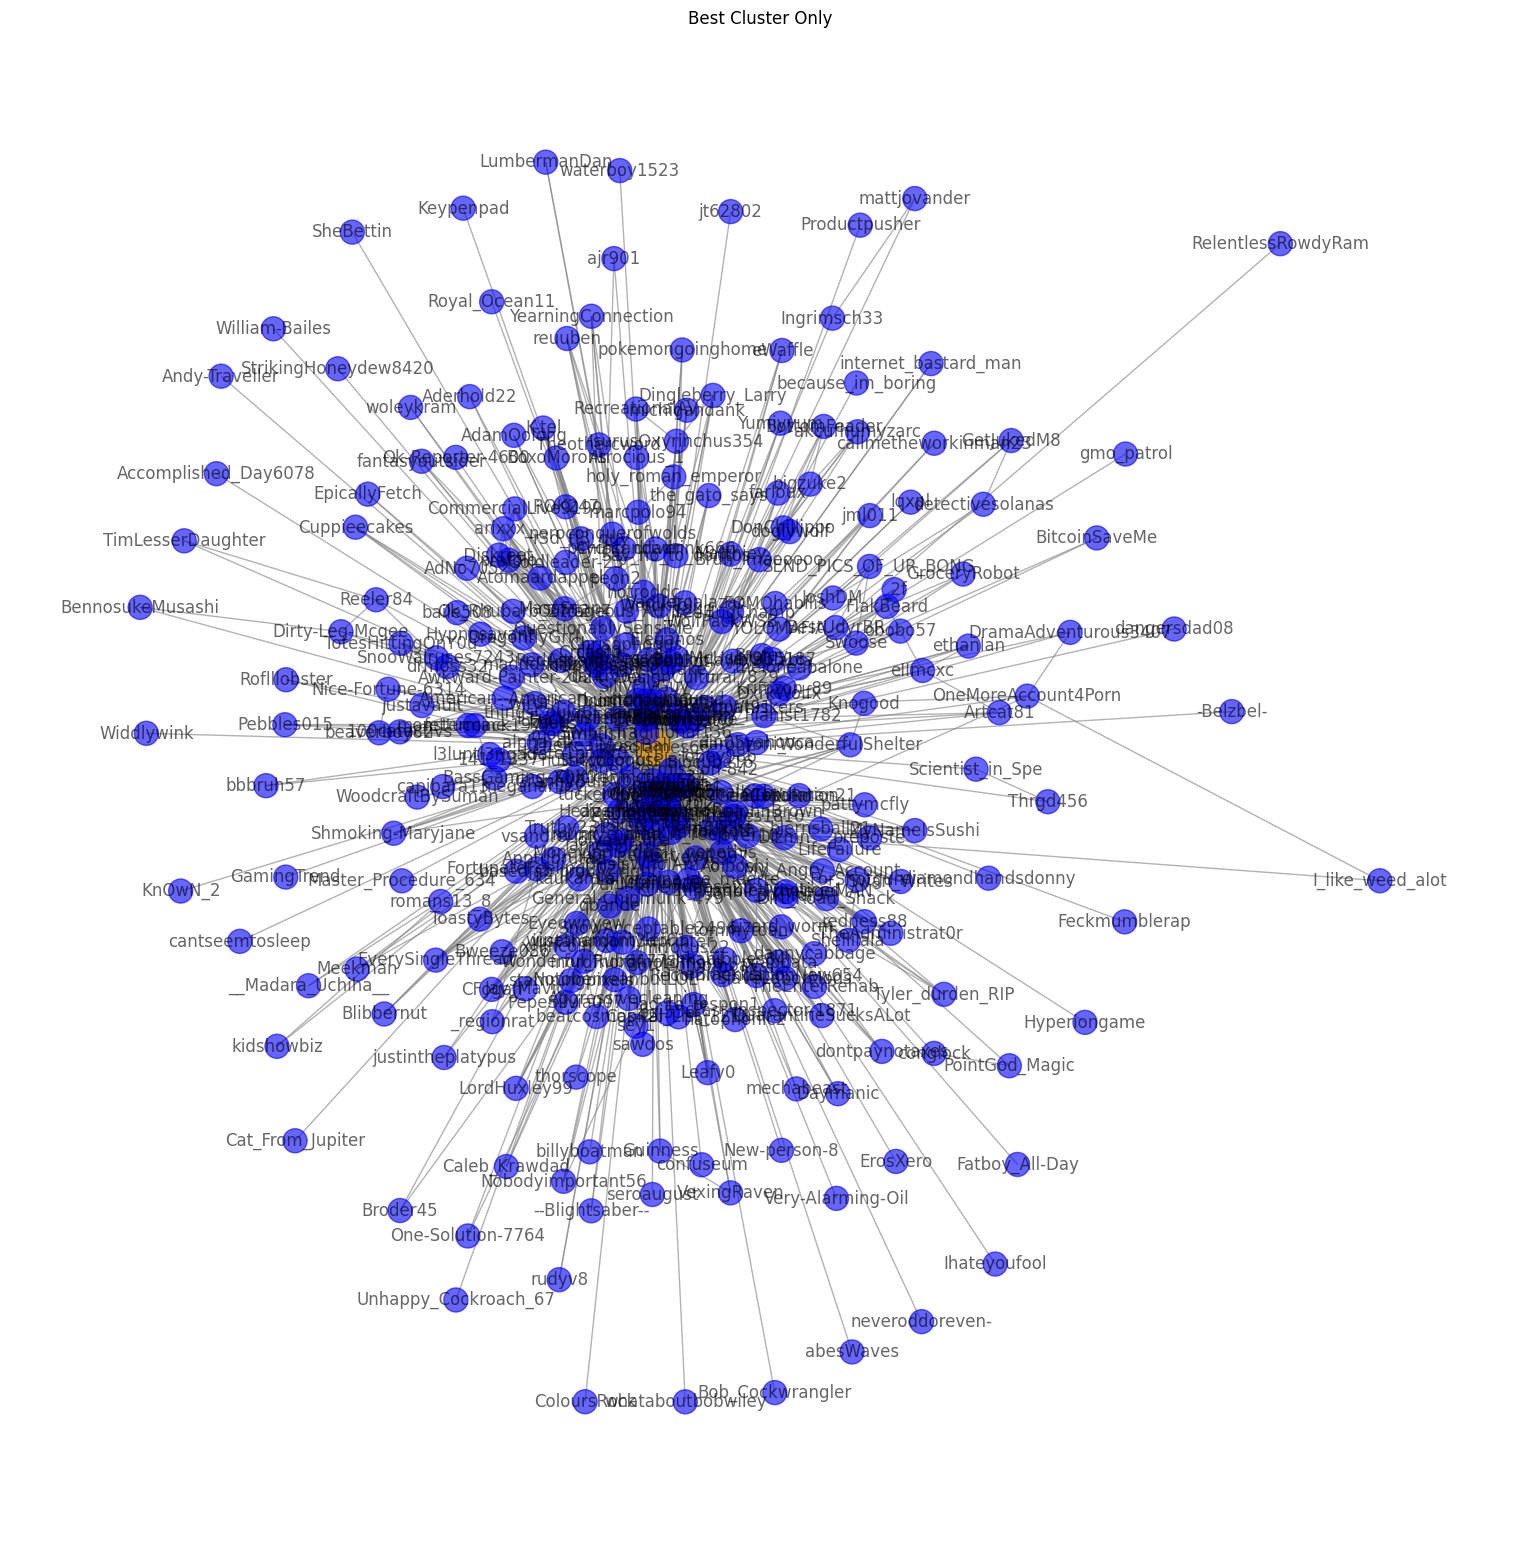

Best community visualization saved as /content/drive/MyDrive/wallstreet_data/main/Original/best_community_filtered_wallstreetbets_AMC.png
Loaded data from /content/drive/MyDrive/wallstreet_data/main/Original/filtered_wallstreetbets_BB.csv
Graph created with 2406 nodes and 4420 edges
Found 19 communities
Best community based on modularity score: ['--throwaway', '-Drazer', '-FuckenDiabolical-', '8IIIIIIIIIID', 'A7araxic', 'AMGems0007', 'ARPcPro', 'Accomplished_Bid2839', 'Aerith_Gainsborough_', 'AlmightyKobra', 'AlphaTheGhost', 'AltBecoming', 'Andrex316', 'Any_Cheesecake5991', 'Article-Rich', 'ArticunoDosTres', 'AskMeHowIMetYourMom', 'Available_Ad300', 'Bankster88', 'Berndbam', 'BigMikeATL8', 'Bmwis', 'Brother_Interesting', 'CRW218', 'Capta1nRon', 'CarlThe94Pathfinder', 'Carloswong420', 'CauliflowerFar3144', 'CelticsHoohaa', 'Cheap-Masterpiece167', 'Chief_White_Halfoat', 'Chinse', 'Choo311', 'Classic_News8985', 'Common_Painting_2749', 'Comprehensive_Wait60', 'Crow2012', 'DJSpacekid', 'DJ_

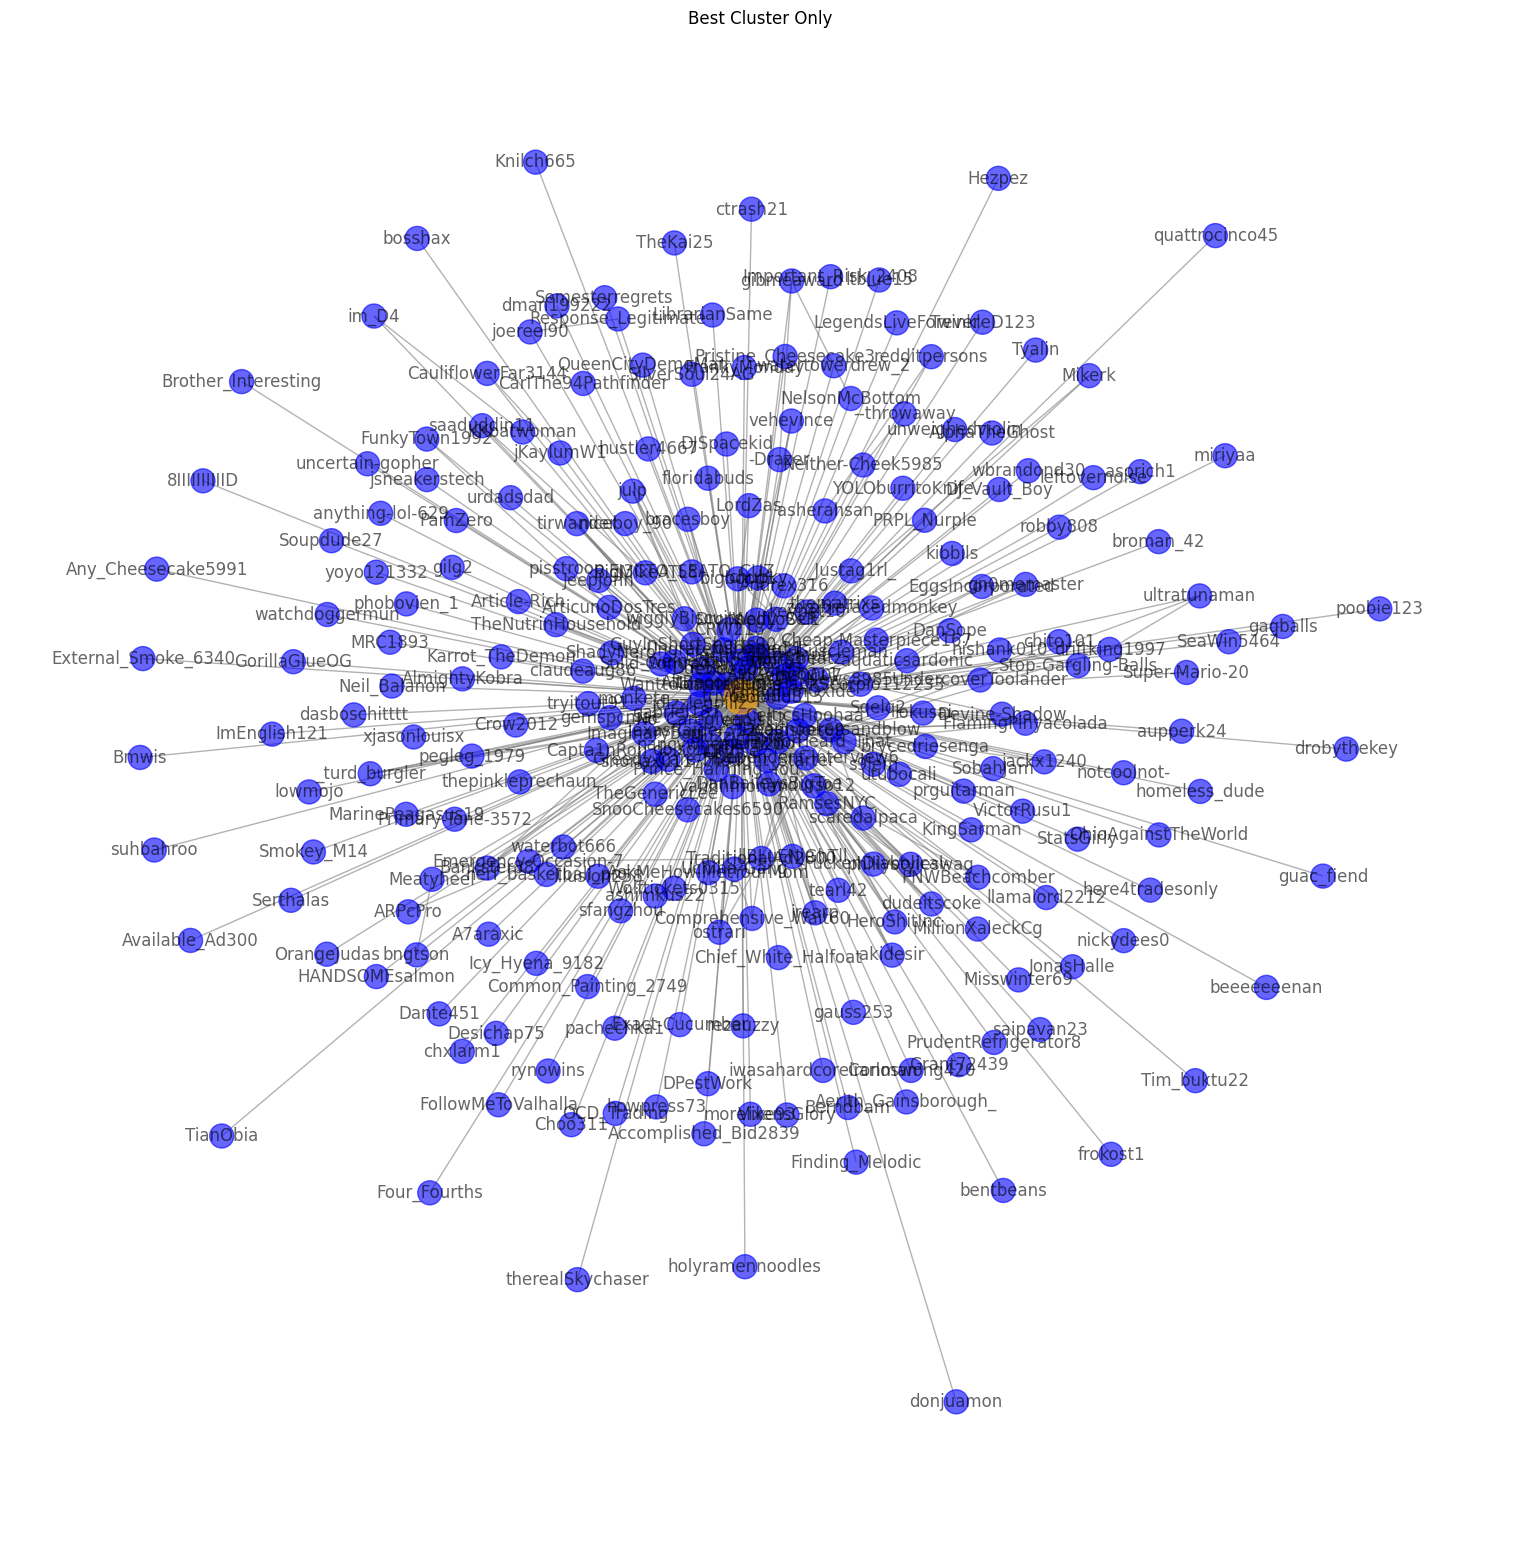

Best community visualization saved as /content/drive/MyDrive/wallstreet_data/main/Original/best_community_filtered_wallstreetbets_BB.png
Loaded data from /content/drive/MyDrive/wallstreet_data/main/Original/filtered_wallstreetbets_GME.csv
Graph created with 5194 nodes and 12461 edges
Found 18 communities
Best community based on modularity score: ['-Seirei-', '05bcrowl', '0xCr0v4x', '17five', '1984Summer', '1english_police', '3Dmommyfart', '510oilcough', '514link', '600300', '69deadlifts', 'Acceptable_Wishbone7', 'Acidmuffin', 'Adamn27', 'AffectionateChart213', 'AgreeableGravy', 'AlwaysBagHolding', 'Ambitious_Relief_151', 'Amyx231', 'Anson845', 'Anudem', 'ApocalypseMao', 'Apollo_Thunderlipps', 'Arcanis_Ender', 'Archensix', 'Artyloo', 'Asiduki99', 'Asinus_Sum', 'Astrosalad', 'AusRtrd', 'Avocadonot', 'BaconBonersBitches', 'Badclamsman', 'Billans1', 'BillyXiaoPin', 'BlackCatArmy99', 'BlindbutAlive', 'BluntTheorist', 'BossPlaya', 'Bostonredditfun', 'BrazenBull', 'Browneboys', 'Buckeye_1121'

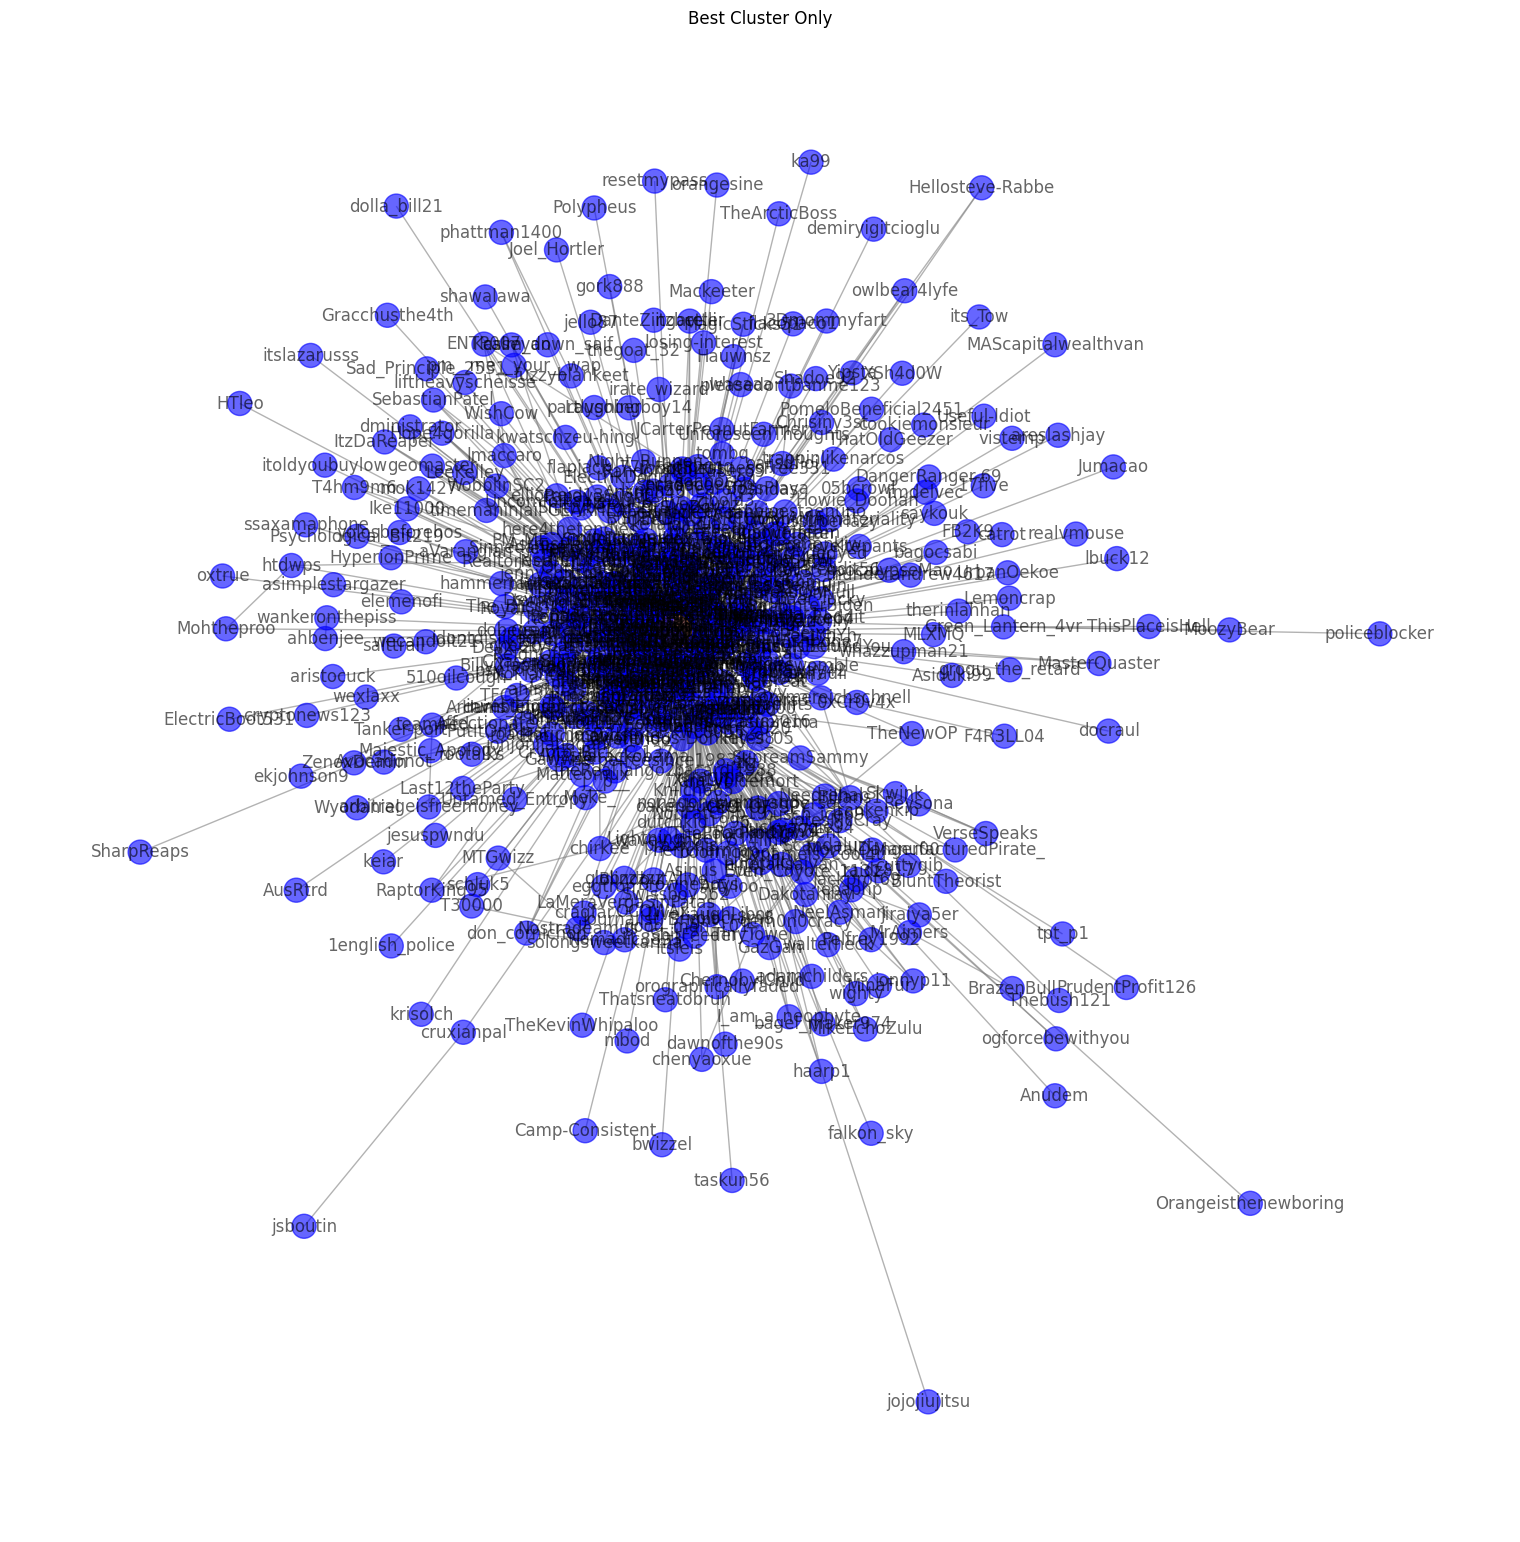

Best community visualization saved as /content/drive/MyDrive/wallstreet_data/main/Original/best_community_filtered_wallstreetbets_GME.png
Loaded data from /content/drive/MyDrive/wallstreet_data/main/Original/filtered_wallstreetbets_KOSS.csv
Graph created with 938 nodes and 1373 edges
Found 52 communities
Best community based on modularity score: ['2CHINZZZ', 'A_R0FLCOPTER', 'Adamn27', 'AustenRodgers', 'AwesomeFaceSpaceBear', 'BAMFC1977', 'BackFun7934', 'Be_a_nice_guy', 'BhinoTL', 'BigWaSkI', 'BroLo75', 'BulltacTV', 'Cat_Marshal', 'Choop-a-loop', 'CoregonusAlbula', 'Desmoire', 'Diacry', 'DickBud', 'Dick_Richardss', 'DnDnDogs', 'Drop_Tables_Username', 'Dusty60', 'Es-Click', 'Esteveno', 'EvlSteveDave', 'FL1ppY_5auR', 'FaberLoomis', 'FiveBrendan', 'FormalWath', 'FullSnackDeveloper87', 'FyrestarOmega', 'GenusHippopotamus', 'Glass_And_Trees', 'Gobbiebags', 'HamishMcdougal', 'HoneyBadger552', 'HyruleJedi', 'Irish_McJesus', 'JRock184', 'Jager1966', 'JeremyJ-32', 'JiraSuxx2', 'Jordynsdaddy', 'J

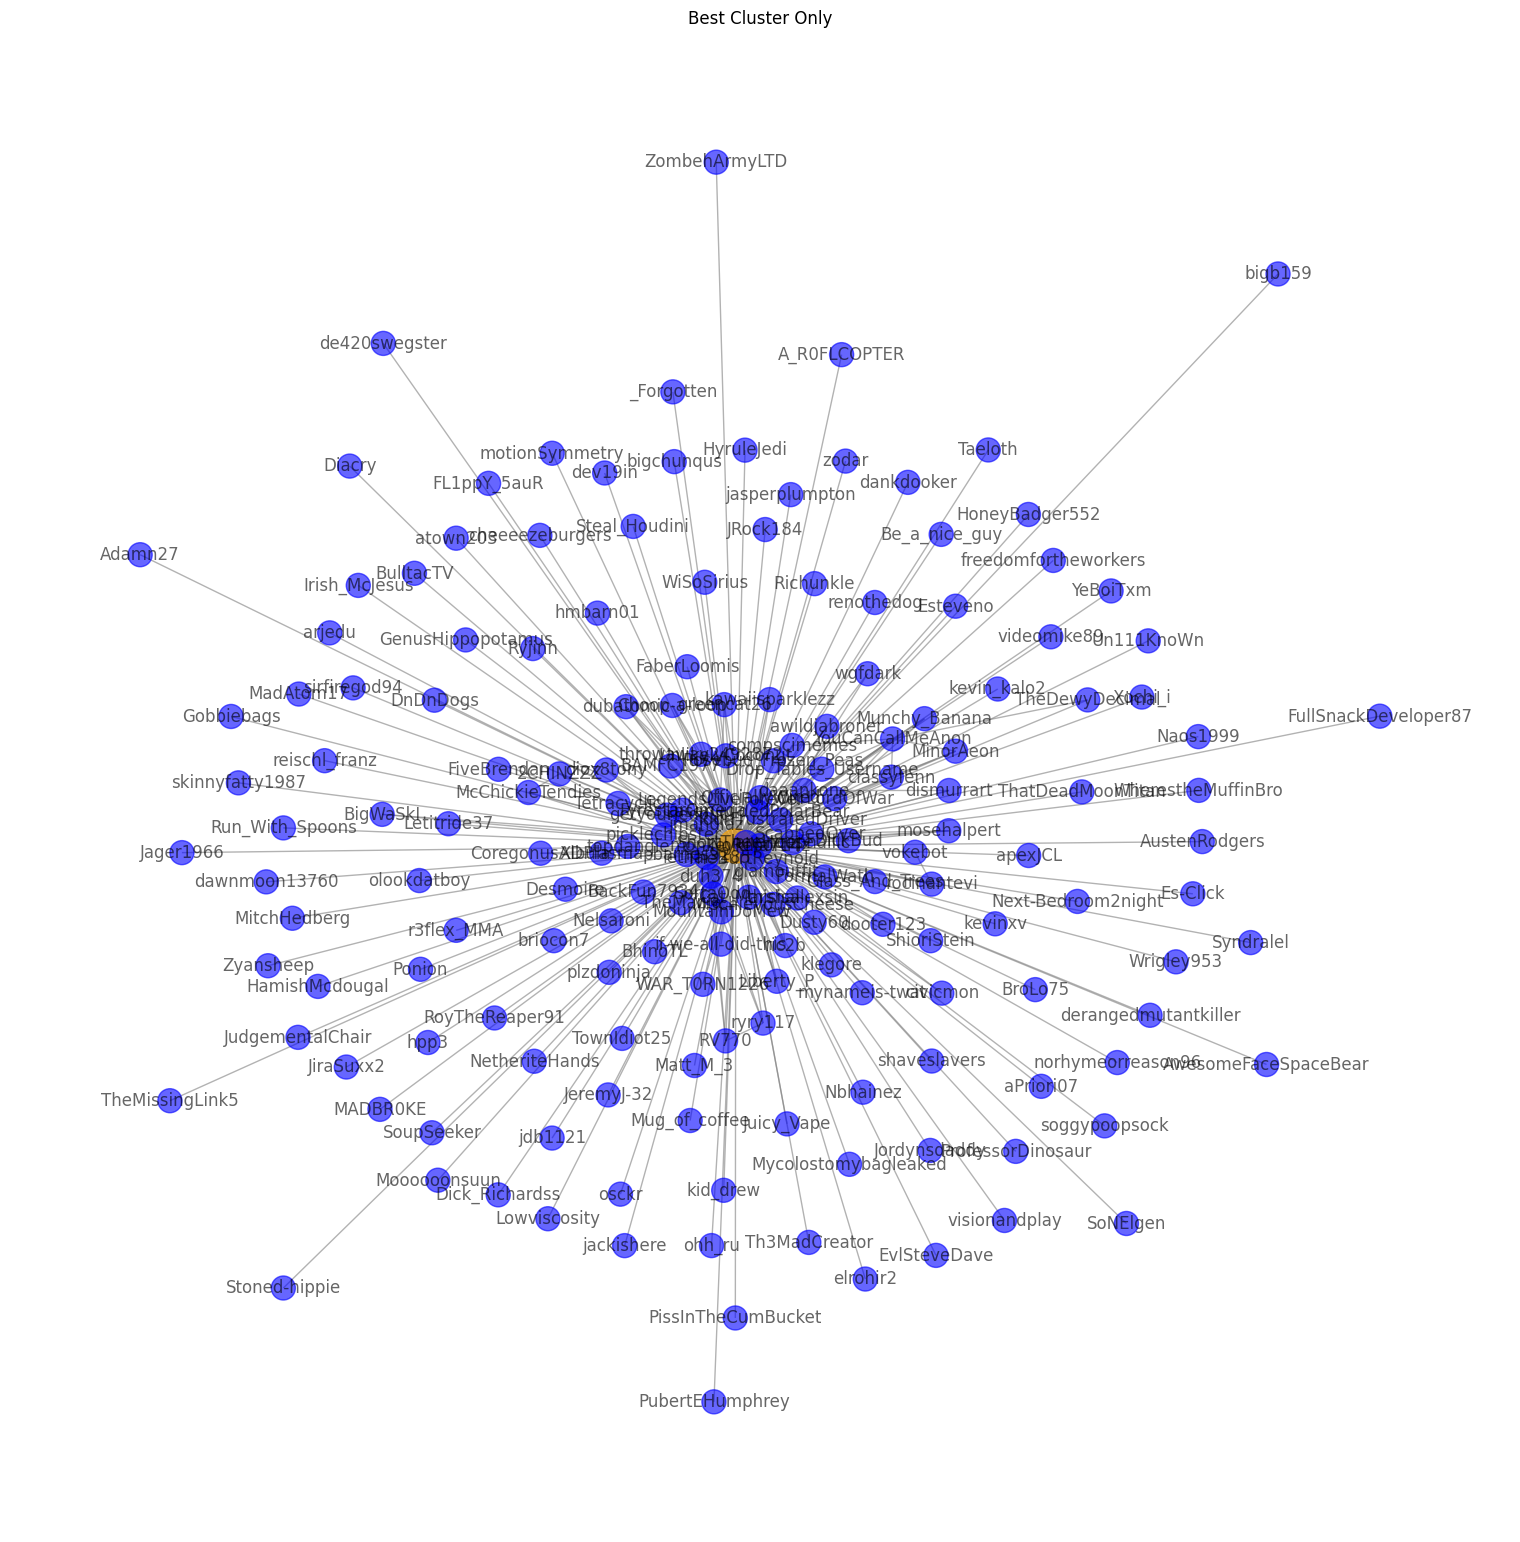

Best community visualization saved as /content/drive/MyDrive/wallstreet_data/main/Original/best_community_filtered_wallstreetbets_KOSS.png


In [ ]:
import os
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt


def create_weighted_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        if row['poster_name'] and row['commenter_name']:
            weight = row['comment_score'] + row['comment_sentiment']
            if weight > 0:
                G.add_edge(row['poster_name'], row['commenter_name'], weight=weight)
        if row['commenter_name'] and row['replier_name']:
            weight = row['reply_score'] + row['reply_sentiment']
            if weight > 0:
                G.add_edge(row['commenter_name'], row['replier_name'], weight=weight)

    G.remove_edges_from(nx.selfloop_edges(G))
    return G


def find_clusters(G):
    partition = community_louvain.best_partition(G, weight='weight')
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)
    return list(communities.values()), partition


def find_best_cluster(G, communities, partition):
    modularity_score = community_louvain.modularity(partition, G)
    best_community = max(communities, key=lambda community: community_louvain.modularity({node: 1 if node in community else 0 for node in G.nodes()}, G))
    best_modularity_score = community_louvain.modularity({node: 1 if node in best_community else 0 for node in G.nodes()}, G)
    print(f"Best community based on modularity score: {sorted(best_community)}")
    print(f"Modularity Score: {best_modularity_score}")
    return best_community


def compute_pagerank(G, best_community):
    subgraph = G.subgraph(best_community)
    pagerank = nx.pagerank(subgraph, weight='weight')
    most_influential = max(pagerank, key=pagerank.get)
    print(f"Most influential user in the best community: {most_influential}")
    print("Top 10 users by PageRank in the best community:")
    for user, score in sorted(pagerank.items(), key=lambda item: item[1], reverse=True)[:10]:
        print(f"{user}: {score}")
    return most_influential, pagerank


def visualize_best_cluster(G, best_community, most_influential, filename):
    subgraph = G.subgraph(best_community)
    pos = nx.spring_layout(subgraph)


    node_sizes = [300 if node != most_influential else 600 for node in subgraph.nodes()]
    node_colors = ['blue' if node != most_influential else 'orange' for node in subgraph.nodes()]

    plt.figure(figsize=(15, 15))
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', alpha=0.6)
    plt.title('Best Cluster Only')
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"Best community visualization saved as {filename}")


def process_files_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.startswith("filtered_") and filename.endswith(".csv"):
            stock_name = filename.split('_')[1].split('.')[0]  # Extract the stock name
            csv_path = os.path.join(directory_path, filename)



            df = pd.read_csv(csv_path)
            print(f"Loaded data from {csv_path}")
           # print(f"Initial data preview:\n{df.head()}")


            G = create_weighted_graph(df)
            print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


            communities, partition = find_clusters(G)
            print(f"Found {len(communities)} communities")


            best_community = find_best_cluster(G, communities, partition)


            most_influential, pagerank = compute_pagerank(G, best_community)


            output_image = os.path.join(directory_path, f"best_community_{os.path.splitext(filename)[0]}.png")
            visualize_best_cluster(G, best_community, most_influential, output_image)


directory_path = '/content/drive/MyDrive/wallstreet_data/main/Original'


process_files_in_directory(directory_path)
